### Обучение полносвязной нейронной сети.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn

### Загружаем данные:

In [83]:
url = "https://raw.githubusercontent.com/SokolovAndrey1/ML_UNN/main/garments_worker_productivity.csv"
data_raw = pd.read_csv(url)

Исключим лишние данные, закодируем дни недели с помощью числовых, бинаризуем признак отдела и нормализуем данные.\
Подробности были приведены в первой лабораторной работе

In [84]:
data = data_raw

data = data.drop(data.loc[:,['date', 'quarter', 'team']], axis = 1)

data['department'] = data['department'].astype('category')
data['day'] = data['day'].astype('category')

data['wip'] = data['wip'].fillna(0)

data['actual_productivity'][data["actual_productivity"] <= 0.75] = 0
data['actual_productivity'] = data['actual_productivity'].astype('bool')  

<ipython-input-84-a95618c5c928>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['actual_productivity'][data["actual_productivity"] <= 0.75] = 0


In [85]:
data['day'] = pd.factorize(data['day'])[0]

department_dummies = pd.get_dummies(data['department'])

data = data.drop(['department'], axis=1)

In [86]:
normalized_data = data.drop(['actual_productivity'], axis=1)

normalized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())

normalized_data = pd.concat((normalized_data, department_dummies), axis=1)

In [87]:
X = normalized_data
y = data['actual_productivity']

### Разбиваем данные на обучающую и тестовую выборки

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

### Обучаем классификатор

In [89]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', alpha = alpha, max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

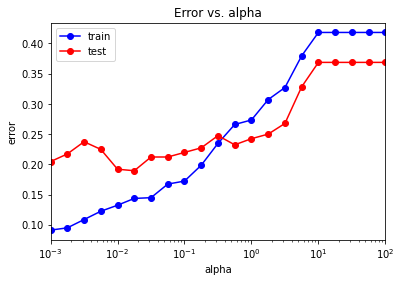

In [91]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Из приведенного графика видно, что при больших значениях alpha происходит недообучение.

In [92]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.09113607990012484 0.1893939393939394


In [93]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.01778279]


Оптимальное значение alpha, соответствующее минимальной ошибке на тестовой выборке

In [94]:
alpha_opt = alpha_opt[0]

Обучим нейронную сеть с одним скрытым слоем. Будем использовать найденное оптимальное значение alpha и изменять колличество нейронов.

In [95]:
first_layer = np.array([5, 8, 10, 12, 15, 20, 25, 30, 40, 50, 70, 100])
test_err = []
train_err = []
for first_neurons_num in first_layer:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (first_neurons_num, ), 
                              solver = 'lbfgs', activation = 'logistic',
                              random_state = 42, max_iter = 5000)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

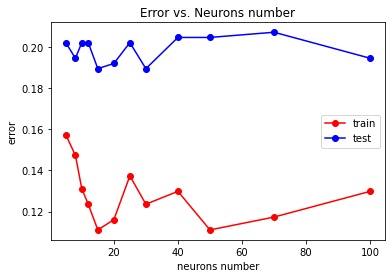

In [96]:
plt.plot(first_layer, train_err, 'r-o', label = 'train')
plt.plot(first_layer, test_err, 'b-o', label = 'test')
plt.title('Error vs. Neurons number')
plt.xlabel('neurons number')
plt.ylabel('error')
plt.legend()
pass

Из выведенного графика видно, что на малом количестве нейронов наблюдается недообучение, поскольку ошибка на обучающей выборке велика относительно более больших значений.

In [97]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.1111111111111111 0.1893939393939394


In [98]:
first_layer_opt = first_layer[test_err == min_test_err]
print(first_layer_opt)

[15 30]


Теперь обучим нейронную сеть с двумя скрытымм слоями и будем изменять колличество нейронов в двух слоях.

In [ ]:
first_layer  = np.array([1, 2, 3, 4, 5, 8, 10, 12, 15, 17, 20, 25, 30, 40])
second_layer = np.array([1, 2, 3, 4, 5, 8, 10, 12, 15, 17, 20, 25, 30, 40])
array_size = len(first_layer)
test_err  = [[0] * array_size] * array_size
train_err = [[0] * array_size] * array_size

idx = 0
jdx = 0

for first_neurons_num in first_layer:
    for second_neurons_num in second_layer:
        mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (first_neurons_num, second_neurons_num), 
                                  solver = 'lbfgs', activation = 'logistic',
                                  random_state = 42, max_iter = 5000)
        mlp_model.fit(X_train, y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)
        train_err[idx][jdx] = np.mean(y_train != y_train_pred)
        test_err[idx][jdx] = np.mean(y_test != y_test_pred)
        jdx += 1
    idx += 1
    jdx = 0

In [114]:
min_train_errors = [0] * array_size
min_test_errors = [0] * array_size

for i in range(array_size):
    min_train_errors[i] = np.min(train_err[i])
    min_test_errors[i] = np.min(test_err[i])

min_train_error = np.min(min_train_errors)
min_test_error = np.min(min_test_errors)
print(min_train_error, min_test_error)

0.04244694132334582 0.19696969696969696


In [115]:
index = [0,0]
for idx in range(array_size):
    for jdx in range(array_size):
        if test_err[idx][jdx] == min_test_error:
            index[0] = idx
            index[1] = jdx
            break
print(first_layer[index[0]], second_layer[index[1]])

40 20


### Вывод
В данной работе были проделаны эксперименты с MLP классификатором. Эксперементальным путем были подобраны параметр alpha, количество скрытых слоёв и количество нейронов в скрытом слое. Полученные данные были проанализированы на предмет выявления переобучения и недообучения при различных значениях параметрах.